In [6]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timm  
import torchvision
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


### VIT TEACHER MODEL

In [ ]:
# Create directory for checkpoints if it doesn't exist
checkpoint_dir = './teacher_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)


# Data Preprocessing : Reszing, Normalizing, Augmentation
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Loading CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_dataset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


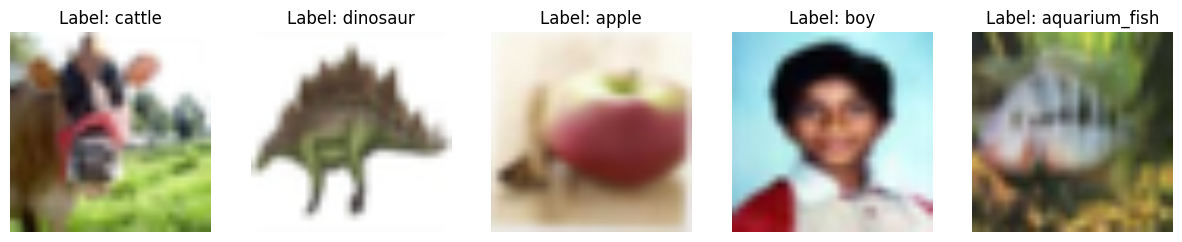

In [ ]:
# Image check
def unnormalize(img):
    img = img * 0.5 + 0.5  
    return img


classes = train_dataset.classes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = train_dataset[i]
    img = unnormalize(img).permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {classes[label]}")
    axes[i].axis('off')
plt.show()


In [ ]:
# Batch shape sample
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break


Batch shape: torch.Size([64, 3, 224, 224])
Labels shape: torch.Size([64])


In [ ]:
# Loading teacher model: ViT-Small 16
teacher_model = timm.create_model('vit_small_patch16_224', pretrained=True)

# Changing classifier head for 100 classes
teacher_model.head = nn.Linear(teacher_model.head.in_features, 100)
teacher_model = teacher_model.to(device)

In [ ]:
# Entire Training Loop


epoch = 10  
p = 2
b_val_loss = float('inf')
early_stop_counter = 0


# Loss function, optimizer, cosine annealing scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch, eta_min=1e-6)


# Lists for metric storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epoch_tracker = []


for epoch in range(1, epoch + 1):
    teacher_model.train()
    running_loss = 0.0
    running_correct = 0
    total_train = 0

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = teacher_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_dataset)
    epoch_train_acc = 100.0 * running_correct / total_train

    # Evaluation phase
    teacher_model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = teacher_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            total_val += labels.size(0)

    epoch_val_loss = val_loss / len(test_dataset)
    epoch_val_acc = 100.0 * val_correct / total_val

    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Train Acc = {epoch_train_acc:.2f}%, "
          f"Val Loss = {epoch_val_loss:.4f}, Val Acc = {epoch_val_acc:.2f}%")

    # Checkpoint saving
    if epoch_val_loss < b_val_loss:
        b_val_loss = epoch_val_loss
        early_stop_counter = 0

        checkpoint_path = os.path.join(checkpoint_dir, f"best_teacher_model_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': teacher_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': epoch_val_loss,
            'val_accuracy': epoch_val_acc,
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= p:
            print("Early stopping triggered.")
            break

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_acc)
    val_accuracies.append(epoch_val_acc)
    epoch_tracker.append(epoch)

# Save metrics into pickle file
metrics = {
    'epoch_tracker': epoch_tracker,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
}
metrics_path = os.path.join(checkpoint_dir, "teacher_training_metrics.pkl")
with open(metrics_path, "wb") as f:
    pickle.dump(metrics, f)
print(f"Training metrics saved to: {metrics_path}")

Epoch 1: Train Loss = 0.7587, Train Acc = 79.58%, Val Loss = 0.4992, Val Acc = 85.18%
Checkpoint saved: ./teacher_checkpoints\best_teacher_model_epoch_1.pth
Epoch 2: Train Loss = 0.2910, Train Acc = 90.97%, Val Loss = 0.4670, Val Acc = 86.90%
Checkpoint saved: ./teacher_checkpoints\best_teacher_model_epoch_2.pth
Epoch 3: Train Loss = 0.1941, Train Acc = 93.82%, Val Loss = 0.4981, Val Acc = 86.22%
Epoch 4: Train Loss = 0.1402, Train Acc = 95.55%, Val Loss = 0.5097, Val Acc = 86.76%
Early stopping triggered.
Training metrics saved to: ./teacher_checkpoints\teacher_training_metrics.pkl


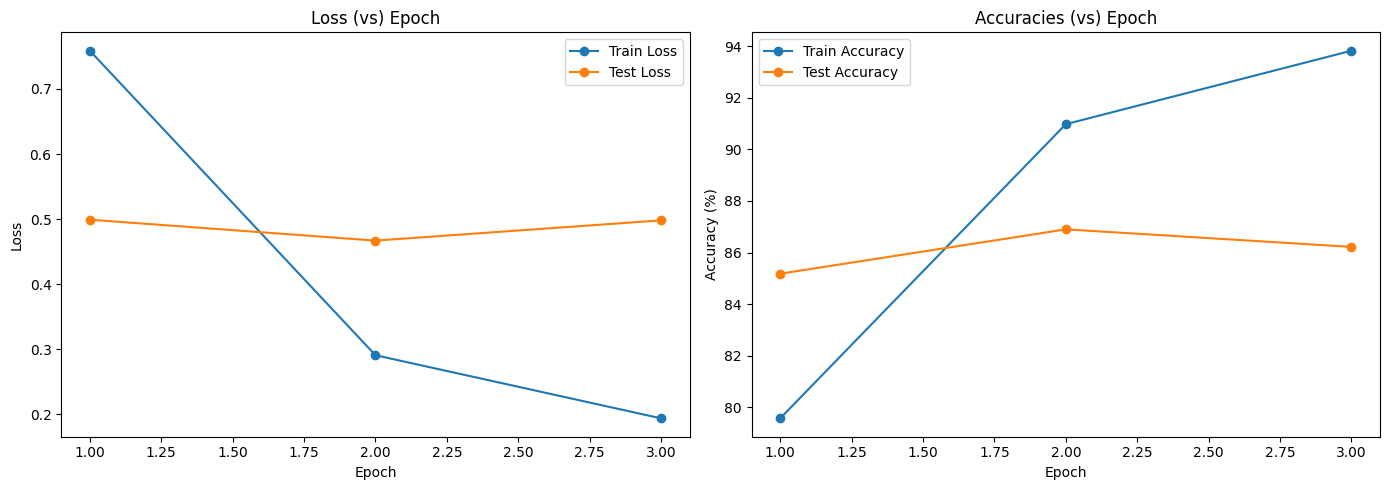

In [ ]:
# Pickle file loading 
metrics_path = './teacher_checkpoints/teacher_training_metrics.pkl'


with open(metrics_path, 'rb') as f:
    metrics = pickle.load(f)

epoch_tracker = metrics['epoch_tracker']
train_losses = metrics['train_losses']
val_losses = metrics['val_losses']
train_accuracies = metrics['train_accuracies']
val_accuracies = metrics['val_accuracies']


# Plotting
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epoch_tracker, train_losses, label="Train Loss", marker='o')
plt.plot(epoch_tracker, val_losses, label="Test Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (vs) Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epoch_tracker, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epoch_tracker, val_accuracies, label="Test Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracies (vs) Epoch")
plt.legend()

plt.tight_layout()
plt.show()


### STUDENT MODEL - ResNet18

In [2]:
# Dir for student checkpoints
checkpoint_dir = './student_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Data Preprocessing : Reszing, Normalizing, Augmentation
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  std=[0.5, 0.5, 0.5])
])

# Loading CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_dataset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Loading student model: ResNet-18 
student_model = models.resnet18(pretrained=True)
num_ftrs = student_model.fc.in_features

# Changing classifier head for 100 classes
student_model.fc = nn.Linear(num_ftrs, 100)  
student_model = student_model.to(device)

c:\Users\csury\anaconda3\envs\att_distill\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\csury\anaconda3\envs\att_distill\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Entire Training Loop

epoch = 20
p = 2
b_val_loss = float('inf')
early_stop_counter = 0

# Loss function, optimizer, cosine annealing scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch, eta_min=1e-6)


# Lists for metric storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epoch_tracker = []

# Main loop
for epoch in range(1, epoch + 1):
    student_model.train()
    running_loss = 0.0
    running_correct = 0
    total_train = 0

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = student_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        running_correct += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = 100.0 * running_correct / total_train

    # Evaluation phase
    student_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = student_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(test_loader.dataset)
    epoch_val_accuracy = 100.0 * correct / total

    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Train Acc = {epoch_train_acc:.2f}%, " \
          f"Test Loss = {epoch_val_loss:.4f}, Test Acc = {epoch_val_accuracy:.2f}%")

    # Checkpoint saving
    if epoch_val_loss < b_val_loss:
        b_val_loss = epoch_val_loss
        early_stop_counter = 0

        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': student_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': epoch_val_loss,
            'val_accuracy': epoch_val_accuracy,
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= p:
            print("Early stopping triggered.")
            break

    scheduler.step()


    train_losses.append(train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_acc)
    val_accuracies.append(epoch_val_accuracy)
    epoch_tracker.append(epoch)

# Save metrics into pickle file
metrics = {
    'epoch_tracker': epoch_tracker,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
}
metrics_path = os.path.join(checkpoint_dir, "training_metrics.pkl")
with open(metrics_path, "wb") as f:
    pickle.dump(metrics, f)
    

Epoch 1: Train Loss = 1.6737, Train Acc = 59.83%, Test Loss = 0.9297, Test Acc = 74.27%
Checkpoint saved: ./student_checkpoints\best_model_epoch_1.pth
Epoch 2: Train Loss = 0.7449, Train Acc = 79.30%, Test Loss = 0.7575, Test Acc = 77.68%
Checkpoint saved: ./student_checkpoints\best_model_epoch_2.pth
Epoch 3: Train Loss = 0.4839, Train Acc = 86.33%, Test Loss = 0.7012, Test Acc = 79.35%
Checkpoint saved: ./student_checkpoints\best_model_epoch_3.pth
Epoch 4: Train Loss = 0.3255, Train Acc = 90.92%, Test Loss = 0.6882, Test Acc = 80.08%
Checkpoint saved: ./student_checkpoints\best_model_epoch_4.pth
Epoch 5: Train Loss = 0.2222, Train Acc = 94.03%, Test Loss = 0.7137, Test Acc = 79.60%
Epoch 6: Train Loss = 0.1565, Train Acc = 95.97%, Test Loss = 0.7176, Test Acc = 79.92%
Early stopping triggered.


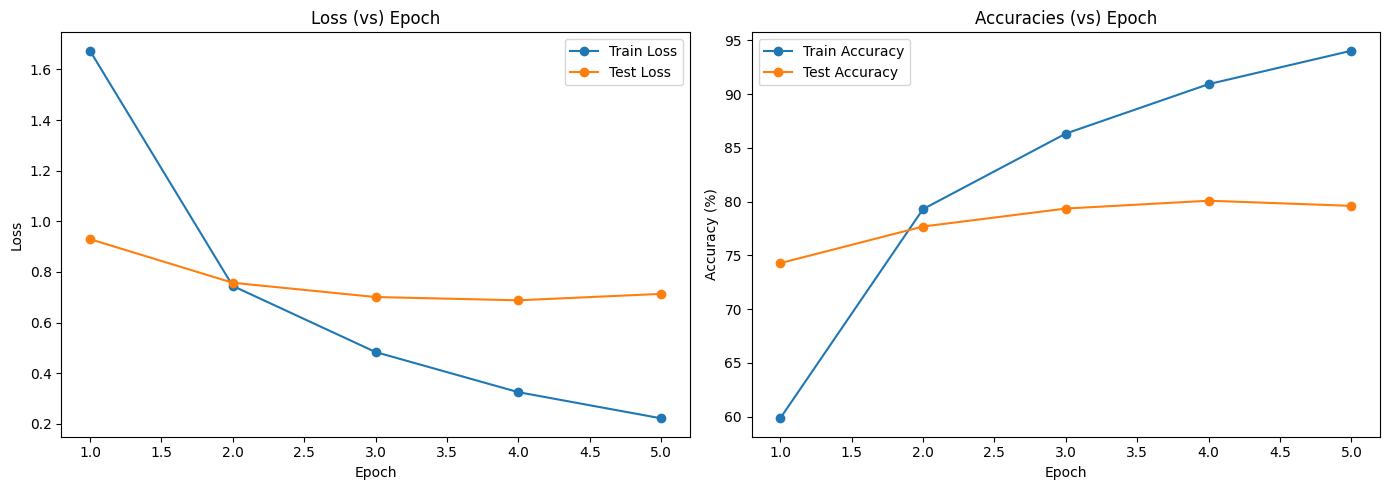

In [9]:
# Pickle file loading 
metrics_path = './student_checkpoints/training_metrics.pkl'


with open(metrics_path, 'rb') as f:
    metrics = pickle.load(f)

epoch_tracker = metrics['epoch_tracker']
train_losses = metrics['train_losses']
val_losses = metrics['val_losses']
train_accuracies = metrics['train_accuracies']
val_accuracies = metrics['val_accuracies']


# Plotting
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epoch_tracker, train_losses, label="Train Loss", marker='o')
plt.plot(epoch_tracker, val_losses, label="Test Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (vs) Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epoch_tracker, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epoch_tracker, val_accuracies, label="Test Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracies (vs) Epoch")
plt.legend()

plt.tight_layout()
plt.show()


### Evaluation along with all metrics

Files already downloaded and verified


C:\Users\csury\AppData\Local\Temp\ipykernel_17540\2712173246.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_checkpoint = torch.load(teacher_checkpoint_path, ma

Teacher (ViT) Parameters: 21704164
Baseline Student (ResNet) Parameters: 11227812

Teacher (ViT) Test Accuracy: 86.90%
Teacher (ViT) Avg Inference Time per Batch: 0.2053 seconds

Teacher Classification Report:
               precision    recall  f1-score   support

        apple       0.99      0.94      0.96       100
aquarium_fish       0.92      0.94      0.93       100
         baby       0.81      0.73      0.77       100
         bear       0.85      0.82      0.84       100
       beaver       0.54      0.90      0.67       100
          bed       0.94      0.81      0.87       100
          bee       0.97      0.94      0.95       100
       beetle       0.93      0.86      0.90       100
      bicycle       0.95      0.93      0.94       100
       bottle       0.96      0.93      0.94       100
         bowl       0.83      0.76      0.79       100
          boy       0.70      0.57      0.63       100
       bridge       0.95      0.90      0.92       100
          bus      

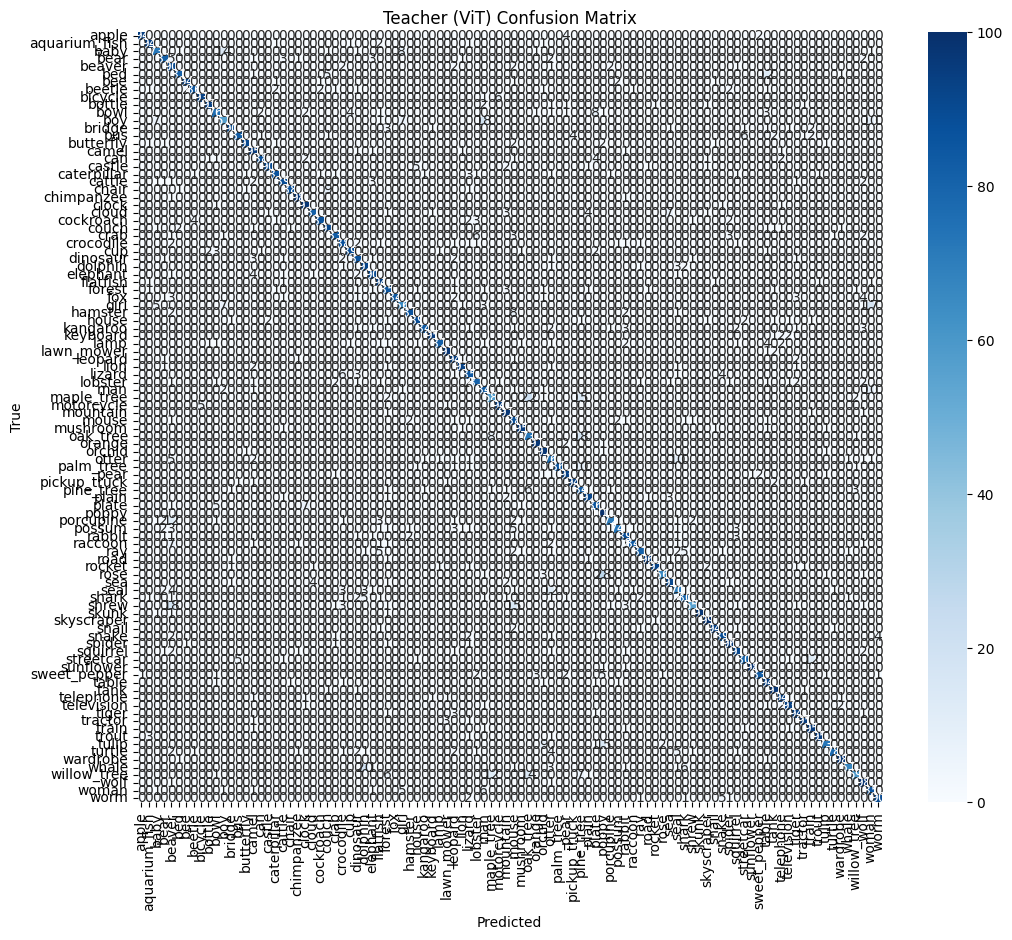

Teacher Per-Class Accuracy:
apple: 94.00%
aquarium_fish: 94.00%
baby: 73.00%
bear: 82.00%
beaver: 90.00%
bed: 81.00%
bee: 94.00%
beetle: 86.00%
bicycle: 93.00%
bottle: 93.00%
bowl: 76.00%
boy: 57.00%
bridge: 90.00%
bus: 83.00%
butterfly: 91.00%
camel: 95.00%
can: 88.00%
castle: 90.00%
caterpillar: 87.00%
cattle: 89.00%
chair: 88.00%
chimpanzee: 98.00%
clock: 97.00%
cloud: 82.00%
cockroach: 87.00%
couch: 91.00%
crab: 83.00%
crocodile: 88.00%
cup: 89.00%
dinosaur: 87.00%
dolphin: 92.00%
elephant: 90.00%
flatfish: 94.00%
forest: 85.00%
fox: 84.00%
girl: 66.00%
hamster: 87.00%
house: 89.00%
kangaroo: 84.00%
keyboard: 95.00%
lamp: 82.00%
lawn_mower: 97.00%
leopard: 94.00%
lion: 93.00%
lizard: 85.00%
lobster: 81.00%
man: 84.00%
maple_tree: 58.00%
motorcycle: 94.00%
mountain: 97.00%
mouse: 88.00%
mushroom: 95.00%
oak_tree: 73.00%
orange: 97.00%
orchid: 97.00%
otter: 76.00%
palm_tree: 86.00%
pear: 93.00%
pickup_truck: 94.00%
pine_tree: 84.00%
plain: 92.00%
plate: 86.00%
poppy: 100.00%
porcupin

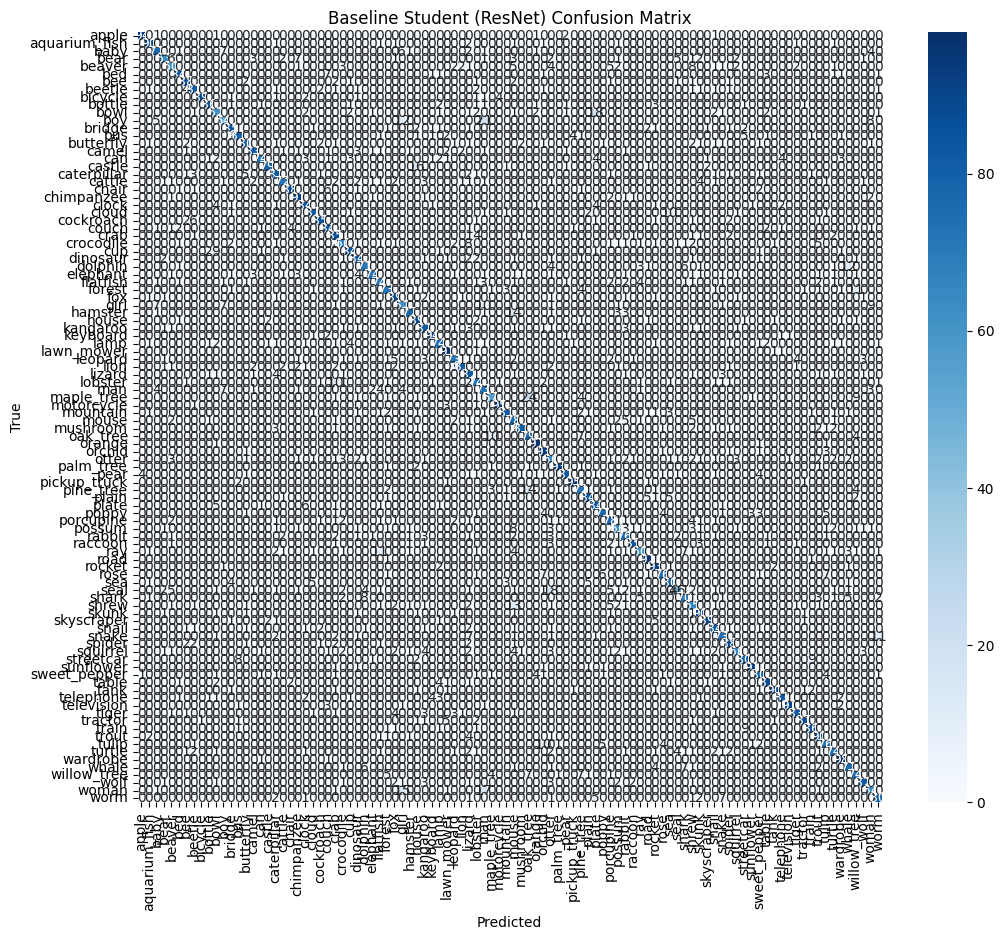

Baseline Student Per-Class Accuracy:
apple: 94.00%
aquarium_fish: 90.00%
baby: 77.00%
bear: 63.00%
beaver: 60.00%
bed: 84.00%
bee: 88.00%
beetle: 82.00%
bicycle: 89.00%
bottle: 86.00%
bowl: 62.00%
boy: 54.00%
bridge: 85.00%
bus: 81.00%
butterfly: 80.00%
camel: 83.00%
can: 74.00%
castle: 79.00%
caterpillar: 82.00%
cattle: 72.00%
chair: 88.00%
chimpanzee: 91.00%
clock: 84.00%
cloud: 82.00%
cockroach: 85.00%
couch: 84.00%
crab: 85.00%
crocodile: 66.00%
cup: 84.00%
dinosaur: 84.00%
dolphin: 71.00%
elephant: 74.00%
flatfish: 74.00%
forest: 73.00%
fox: 89.00%
girl: 62.00%
hamster: 77.00%
house: 89.00%
kangaroo: 82.00%
keyboard: 94.00%
lamp: 74.00%
lawn_mower: 97.00%
leopard: 73.00%
lion: 81.00%
lizard: 82.00%
lobster: 74.00%
man: 73.00%
maple_tree: 57.00%
motorcycle: 95.00%
mountain: 81.00%
mouse: 78.00%
mushroom: 81.00%
oak_tree: 79.00%
orange: 97.00%
orchid: 93.00%
otter: 66.00%
palm_tree: 93.00%
pear: 82.00%
pickup_truck: 95.00%
pine_tree: 72.00%
plain: 84.00%
plate: 84.00%
poppy: 77.00%


In [ ]:
# Data Preprocessing
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Loading dataset
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)


# Evaluation
def evaluate_model(model, dataloader, device):

    model.eval()
    total, correct = 0, 0
    all_preds = []
    all_labels = []
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs
            preds = torch.argmax(logits, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    inference_time = time.time() - start_time
    avg_time_per_batch = inference_time / len(dataloader)
    accuracy = 100.0 * correct / total
    return accuracy, avg_time_per_batch, np.array(all_preds), np.array(all_labels)

# Confusion Matrix 
def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Per-Class Accuracy
def per_class_accuracy(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = {}
    for i, label in enumerate(classes):
        total = cm[i, :].sum()
        per_class_acc[label] = 100.0 * cm[i, i] / total if total != 0 else 0.0
    return per_class_acc

def count_params(model):
    """Return the number of trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Loading trained teacher model
teacher_checkpoint_path = os.path.join('./teacher_checkpoints', 'best_teacher_model_epoch_2.pth')
teacher_checkpoint = torch.load(teacher_checkpoint_path, map_location=device)

teacher_model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=100)
teacher_model.load_state_dict(teacher_checkpoint['model_state_dict'])
teacher_model.to(device)


# Loading trained student model
student_checkpoint_path = os.path.join('./student_checkpoints', 'best_model_epoch_4.pth')
student_checkpoint = torch.load(student_checkpoint_path, map_location=device)

student_model = models.resnet18(num_classes=100)
student_model.load_state_dict(student_checkpoint['model_state_dict'])
student_model.to(device)


# Parameters check
teacher_params = count_params(teacher_model)
student_params = count_params(student_model)
print(f"Teacher (ViT) Parameters: {teacher_params}")
print(f"Baseline Student (ResNet) Parameters: {student_params}")


classes = test_dataset.classes

# Printing metrics
teacher_accuracy, teacher_avg_time, teacher_preds, teacher_labels = evaluate_model(teacher_model, test_loader, device)
print(f"\nTeacher (ViT) Test Accuracy: {teacher_accuracy:.2f}%")
print(f"Teacher (ViT) Avg Inference Time per Batch: {teacher_avg_time:.4f} seconds")
print("\nTeacher Classification Report:")
print(classification_report(teacher_labels, teacher_preds, target_names=classes))
plot_confusion_matrix(teacher_labels, teacher_preds, classes, title="Teacher (ViT) Confusion Matrix")
teacher_per_class = per_class_accuracy(teacher_labels, teacher_preds, classes)
print("Teacher Per-Class Accuracy:")
for cls, acc in teacher_per_class.items():
    print(f"{cls}: {acc:.2f}%")


student_accuracy, student_avg_time, student_preds, student_labels = evaluate_model(student_model, test_loader, device)
print(f"\nBaseline Student (ResNet) Test Accuracy: {student_accuracy:.2f}%")
print(f"Baseline Student (ResNet) Avg Inference Time per Batch: {student_avg_time:.4f} seconds")
print("\nBaseline Student Classification Report:")
print(classification_report(student_labels, student_preds, target_names=classes))
plot_confusion_matrix(student_labels, student_preds, classes, title="Baseline Student (ResNet) Confusion Matrix")
student_per_class = per_class_accuracy(student_labels, student_preds, classes)
print("Baseline Student Per-Class Accuracy:")
for cls, acc in student_per_class.items():
    print(f"{cls}: {acc:.2f}%")
